# k-means clustering

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [2]:
data = pd.read_csv('data_cluster_test2.csv')
pd.set_option('display.max_columns', None)
data

,id,listing_url,host_id,host_url,host_since,host_location,host_response_time,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Host_location_germany,Host_location_berlin,host_response_rate_category,bathrooms_type,bathroom_qty,aman,Kitchen,Heating,Essentials,Washer,Long term stays allowed,Hair dryer,Wifi,Hangers,Dedicated workspace,Iron,Smoke alarm,Dishes and silverware,Shampoo,Refrigerator,Cooking basics,Hot water,Bed linens,Stove,Coffee maker,Oven,TV,Free street parking,Wifi.1,Host greets you,Microwave,Elevator,Extra pillows and blankets,Dishwasher,Luggage dropoff allowed,Private entrance,Fire extinguisher,Carbon monoxide alarm,Hot water.1,Patio or balcony,Dryer,Cable TV,Bathtub,Lock on bedroom door,First aid kit,Shower gel,Baking sheet,Hot water kettle,Free parking on premises,Single level home,Dining table,Freezer,Room-darkening shades,Wine glasses,Paid parking off premises,TV with standard cable,Toaster,Cleaning products,First aid kit.1,High chair,Body soap,Essentials,Dishwasher.1,Drying rack for clothing,Backyard,Crib
0,2015,https://www.airbnb.com/rooms/2015,2217,https://www.airbnb.com/users/show/2217,1970,"Key Biscayne, Florida, United States",within an hour,1,5.0,['email'],1,0,Brunnenstr. Süd,Mitte,52.533050,13.403940,Entire guesthouse,Entire home/apt,2,1,2,"[""Essentials"", ""Heating"", ""Backyard"", ""Long te...",53.0,90,1125,2.0,90.0,1125.0,1125.0,84.3,1125.0,1,28,58,64,326,144,10,0,2016-04-11,2021-11-02,4.66,4.79,4.52,4.88,4.90,4.96,4.58,0,4,4,0,0,2.08,False,False,High,private,1.0,"[Essentials, Heating, Backyard, Long term stay...",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,3176,https://www.airbnb.com/rooms/3176,3718,https://www.airbnb.com/users/show/3718,1970,"Coledale, New South Wales, Australia",no request,0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",1,1,Prenzlauer Berg Südwest,Pankow,52.534710,13.418100,Entire rental unit,Entire home/apt,4,1,2,"[""Essentials"", ""Heating"", ""Smoke alarm"", ""Iron...",90.0,92,1125,92.0,92.0,1125.0,1125.0,92.0,1125.0,1,0,0,0,170,147,1,0,2009-06-20,2021-01-01,4.63,4.68,4.53,4.64,4.69,4.92,4.63,0,1,1,0,0,0.97,False,False,No request,private,1.0,"[Essentials, Heating, Smoke alarm, Iron, Washe...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7071,https://www.airbnb.com/rooms/7071,17391,https://www.airbnb.com/users/show/17391,1970,"Berlin, Berlin, Germany",no request,1,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Helmholtzplatz,Pankow,52.543010,13.415340,Private room in rental unit,Private room,2,1,2,"[""Essentials"", ""Heating"", ""Refrigerator"", ""Hai...",33.0,1,10,1.0,1.0,10.0,10.0,1.0,10.0,1,0,0,0,0,293,0,0,2009-08-18,2020-03-31,4.83,4.85,4.90,4.86,4.85,4.91,4.71,1,1,0,1,0,1.95,True,True,No re

## filter listings for last recieved review

In [3]:
print(data['last_review'].dtypes)

object


In [4]:
#filter the data
#take only data which had last review within 2021 and 2020 --> more recently active ones
print(pd.to_datetime(data.last_review).dt.year.value_counts())
data2=data[pd.to_datetime(data.last_review).dt.year>2019]

2021    6117
2020    2172
2019    1912
2018    1329
2017    1067
2016     837
2015     405
2014      40
2012       2
2013       2
Name: last_review, dtype: int64


In [5]:
data_original=data2.copy()

In [6]:
data_original.shape

(8289, 120)

In [7]:
print(pd.to_datetime(data2.last_review).dt.year.value_counts())

2021    6117
2020    2172
Name: last_review, dtype: int64


In [8]:
data2.shape

(8289, 120)

## select features

In [9]:
#select important features to cluster possible professional and non-professional airbnbs

#room type:entire home, private room, shared room --> need in boolean, dummy encode

#review per month(number of reviews over lifeitme of listing): could hint to activity of listing
#--> log transform

#host_is_superhost: very good ratings from customers

#host identitiy_verified: could give a hint about profesiionalism

#instant_bookable: can give a hint about professinalism

#bathrooms_type: a private is more like hotel, shared less profesional listing
#--> needs to be in boolean, dummy encode

#minimum_nights_avg_ntm	:the average minimum nighs booking from the calender --> log transform
#how long people stay could indicate if it can still be used privately

#calculated_host_listings_count: a host ho has many listings looks more like he would use airbnb professinal
#--> log transform


##difficult to use:


#price itself has no deeper meaning, rather income of each listing would be helpful

#think about ammenities: maybe not every ammentiie listed but total number of ammenities for each listing?

#avaliability_365: shows how long the listing is avialable for 365 days in the future
#however if its already booked or blocked by host its shown as not available

#review rating might be problematic


In [10]:
#room_type
data2=pd.get_dummies(data2, columns=["room_type"])

In [11]:
data2.bathrooms_type.value_counts()

private    6117
shared     2172
Name: bathrooms_type, dtype: int64

In [12]:
data2=pd.get_dummies(data2, columns=["bathrooms_type"])

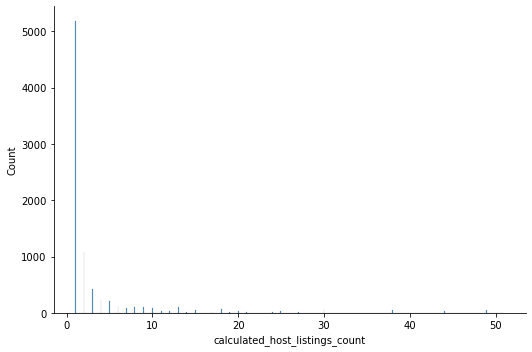

In [13]:
sns.displot(data=data2, x="calculated_host_listings_count", kind="hist", aspect=1.5)

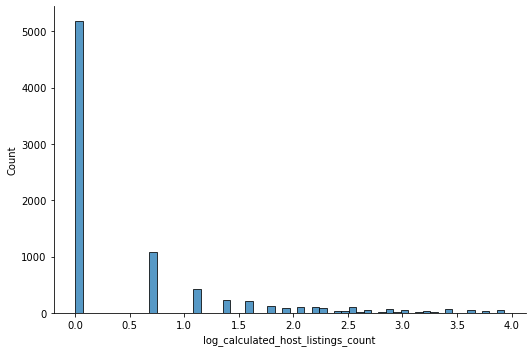

In [14]:
#log transform
data2.loc[:,"log_calculated_host_listings_count"] = np.log(data2.loc[:,"calculated_host_listings_count"])
#plot
sns.displot(data=data2, x="log_calculated_host_listings_count", kind="hist", aspect=1.5)
#drop price
#data2.drop('price', axis=1,inplace=True)

In [15]:
data2.instant_bookable.value_counts()

0    5481
1    2808
Name: instant_bookable, dtype: int64

In [16]:
data2.host_identity_verified.value_counts()

1    7414
0     875
Name: host_identity_verified, dtype: int64

In [17]:
data2.host_is_superhost.value_counts()

0    5929
1    2360
Name: host_is_superhost, dtype: int64

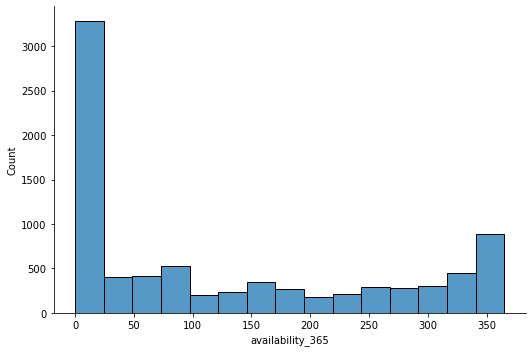

In [18]:
sns.displot(data=data2, x="availability_365", kind="hist", aspect=1.5)
# listing can be nit available in the future because it has been booked or blocked by the host
#doesnt seem to be useful

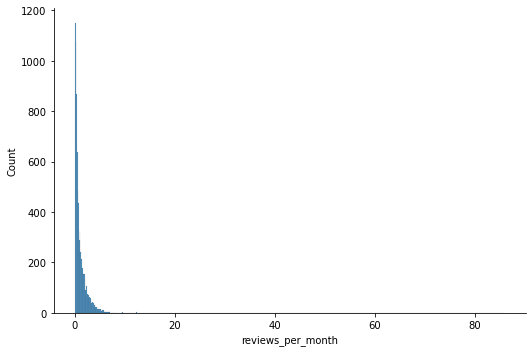

In [19]:
sns.displot(data=data2, x="reviews_per_month", kind="hist", aspect=1.5)

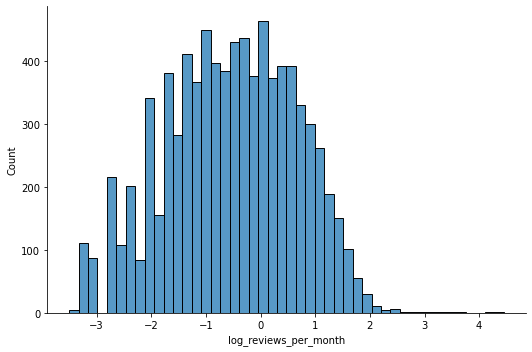

In [20]:
#log transform
data2.loc[:,"log_reviews_per_month"] = np.log(data2.loc[:,"reviews_per_month"])
#plot
sns.displot(data=data2, x="log_reviews_per_month", kind="hist", aspect=1.5)

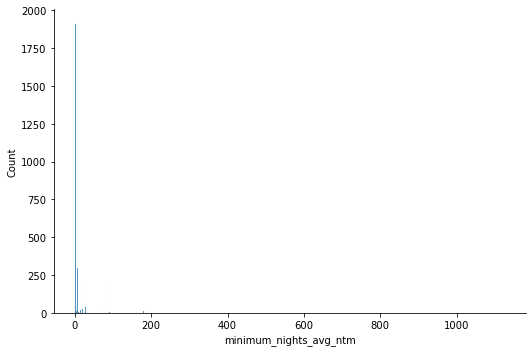

In [21]:
sns.displot(data=data2, x="minimum_nights_avg_ntm", kind="hist", aspect=1.5)

In [22]:
data2[data2.minimum_nights_avg_ntm==0].shape #no data with zero values

(0, 125)

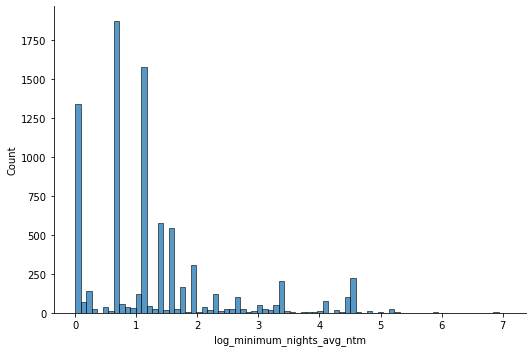

In [23]:
#log transform
data2.loc[:,"log_minimum_nights_avg_ntm"] = np.log(data2.loc[:,"minimum_nights_avg_ntm"])
#plot
sns.displot(data=data2, x="log_minimum_nights_avg_ntm", kind="hist", aspect=1.5)
#drop price
#data2.drop('price', axis=1,inplace=True)

In [24]:
data2

,id,listing_url,host_id,host_url,host_since,host_location,host_response_time,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Host_location_germany,Host_location_berlin,host_response_rate_category,bathroom_qty,aman,Kitchen,Heating,Essentials,Washer,Long term stays allowed,Hair dryer,Wifi,Hangers,Dedicated workspace,Iron,Smoke alarm,Dishes and silverware,Shampoo,Refrigerator,Cooking basics,Hot water,Bed linens,Stove,Coffee maker,Oven,TV,Free street parking,Wifi.1,Host greets you,Microwave,Elevator,Extra pillows and blankets,Dishwasher,Luggage dropoff allowed,Private entrance,Fire extinguisher,Carbon monoxide alarm,Hot water.1,Patio or balcony,Dryer,Cable TV,Bathtub,Lock on bedroom door,First aid kit,Shower gel,Baking sheet,Hot water kettle,Free parking on premises,Single level home,Dining table,Freezer,Room-darkening shades,Wine glasses,Paid parking off premises,TV with standard cable,Toaster,Cleaning products,First aid kit.1,High chair,Body soap,Essentials,Dishwasher.1,Drying rack for clothing,Backyard,Crib,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bathrooms_type_private,bathrooms_type_shared,log_calculated_host_listings_count,log_reviews_per_month,log_minimum_nights_avg_ntm
0,2015,https://www.airbnb.com/rooms/2015,2217,https://www.airbnb.com/users/show/2217,1970,"Key Biscayne, Florida, United States",within an hour,1,5.0,['email'],1,0,Brunnenstr. Süd,Mitte,52.533050,13.403940,Entire guesthouse,2,1,2,"[""Essentials"", ""Heating"", ""Backyard"", ""Long te...",53.0,90,1125,2.0,90.0,1125.0,1125.0,84.3,1125.0,1,28,58,64,326,144,10,0,2016-04-11,2021-11-02,4.66,4.79,4.52,4.88,4.90,4.96,4.58,0,4,4,0,0,2.08,False,False,High,1.0,"[Essentials, Heating, Backyard, Long term stay...",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,0,0,1,0,1.386294,0.732368,4.434382
1,3176,https://www.airbnb.com/rooms/3176,3718,https://www.airbnb.com/users/show/3718,1970,"Coledale, New South Wales, Australia",no request,0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",1,1,Prenzlauer Berg Südwest,Pankow,52.534710,13.418100,Entire rental unit,4,1,2,"[""Essentials"", ""Heating"", ""Smoke alarm"", ""Iron...",90.0,92,1125,92.0,92.0,1125.0,1125.0,92.0,1125.0,1,0,0,0,170,147,1,0,2009-06-20,2021-01-01,4.63,4.68,4.53,4.64,4.69,4.92,4.63,0,1,1,0,0,0.97,False,False,No request,1.0,"[Essentials, Heating, Smoke alarm, Iron, Washe...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,1,0,0.000000,-0.030459,4.521789
2,7071,https://www.airbnb.com/rooms/7071,17391,https://www.airbnb.com/users/show/17391,1970,"Berlin, Berlin, Germany",no request,1,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Helmholtzplatz,Pankow,52.543010,13.415340,Private room in rental unit,2,1,2,"[""Essentia

In [25]:
#boolean data
cols1=['room_type_Entire home/apt','room_type_Private room','room_type_Shared room',
     'host_is_superhost','host_identity_verified','instant_bookable','bathrooms_type_private','bathrooms_type_shared']

#continious data needs scaling
cols2=['log_reviews_per_month','log_minimum_nights_avg_ntm','log_calculated_host_listings_count']

data_select_bool=data2[cols1].copy()
data_select_conti=data2[cols2].copy()
display(data_select_bool.head(1))
display(data_select_conti.head(1))

,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost,host_identity_verified,instant_bookable,bathrooms_type_private,bathrooms_type_shared
0,1,0,0,1,0,0,1,0


,log_reviews_per_month,log_minimum_nights_avg_ntm,log_calculated_host_listings_count
0,0.732368,4.434382,1.386294


In [26]:
data_select_bool

,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost,host_identity_verified,instant_bookable,bathrooms_type_private,bathrooms_type_shared
0,1,0,0,1,0,0,1,0
1,1,0,0,0,1,0,1,0
2,0,1,0,1,1,1,0,1
3,1,0,0,0,1,0,1,0
4,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...
13878,1,0,0,0,1,0,1,0
13879,1,0,0,0,1,1,1,0
13880,0,1,0,0,1,1,0,1
13881,1,0,0,0,1,0,1,0


In [27]:
# K-Means is a distance based algorithm: scaling needed
data_select_conti_scaled = StandardScaler().fit_transform(data_select_conti)

# Now, all features will have the same weight.
df_conti_scaled=pd.DataFrame(data_select_conti_scaled,columns=data_select_conti.columns)
df_conti_scaled

,log_reviews_per_month,log_minimum_nights_avg_ntm,log_calculated_host_listings_count
0,1.075374,2.739150,0.833278
1,0.432870,2.814852,-0.622934
2,1.021015,-1.101451,-0.622934
3,-1.480865,0.450385,-0.622934
4,-0.940253,2.842644,0.531087
...,...,...,...
8284,0.458525,-0.149948,-0.622934
8285,0.458525,-1.101451,-0.622934
8286,0.458525,-1.101451,3.507194
8287,0.458525,-0.501119,-0.622934


In [28]:
#reset index
data_select_bool.reset_index(inplace=True, drop=True)

#concat boolean and scaled continious data
data_cluster = pd.concat([data_select_bool, df_conti_scaled], axis=1)
data_cluster


,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost,host_identity_verified,instant_bookable,bathrooms_type_private,bathrooms_type_shared,log_reviews_per_month,log_minimum_nights_avg_ntm,log_calculated_host_listings_count
0,1,0,0,1,0,0,1,0,1.075374,2.739150,0.833278
1,1,0,0,0,1,0,1,0,0.432870,2.814852,-0.622934
2,0,1,0,1,1,1,0,1,1.021015,-1.101451,-0.622934
3,1,0,0,0,1,0,1,0,-1.480865,0.450385,-0.622934
4,1,0,0,1,1,0,1,0,-0.940253,2.842644,0.531087
...,...,...,...,...,...,...,...,...,...,...,...
8284,1,0,0,0,1,0,1,0,0.458525,-0.149948,-0.622934
8285,1,0,0,0,1,1,1,0,0.458525,-1.101451,-0.622934
8286,0,1,0,0,1,1,0,1,0.458525,-1.101451,3.507194
8287,1,0,0,0,1,0,1,0,0.458525,-0.501119,-0.622934


## elbow & silhouette

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

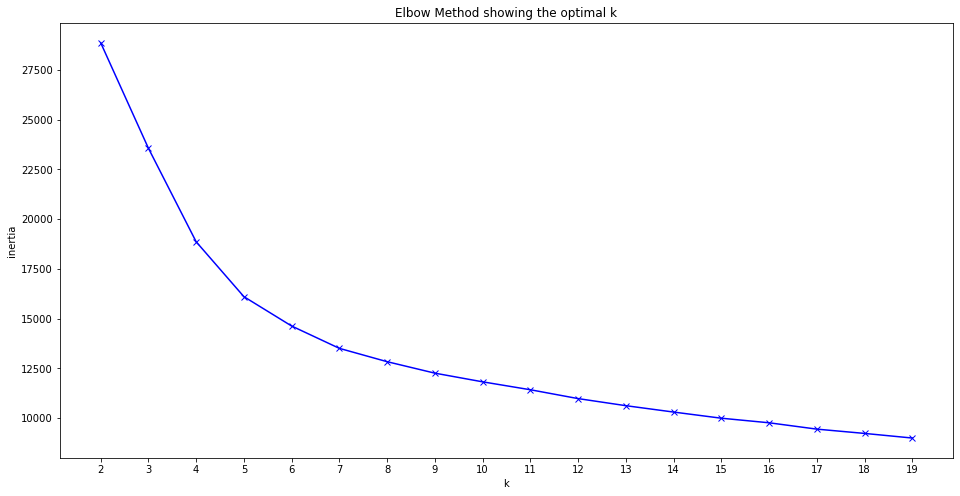

In [174]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    
                    random_state=1234)
    kmeans.fit(data_cluster)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [ ]:
#pick k at the spot where SSE (inertia) starts to flatten out and forming an elbow
#we want silhouette score to be as big as possible, while reducing inertia

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

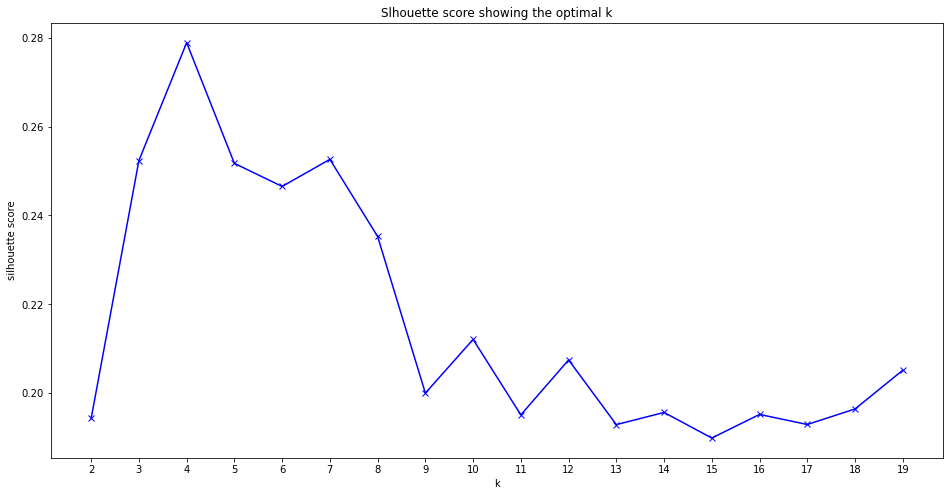

In [170]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    
                    random_state=1234)
    kmeans.fit(data_cluster)
    silhouette.append(silhouette_score(data_cluster, kmeans.predict(data_cluster)))
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

## create new improved kMeans model

In [161]:
kmeans = KMeans(n_clusters=4,
                random_state=1234)
kmeans.fit(data_cluster)
print(kmeans.inertia_)

clusters = kmeans.predict(data_cluster)
pd.Series(clusters).value_counts().sort_index()


18864.20217050432


0    3553
1    1405
2    2422
3     909
dtype: int64

In [162]:
centroids = kmeans.cluster_centers_
centroids

array([[ 9.98592739e-01,  1.40726147e-03,  7.80625564e-17,
         2.60061920e-01,  8.86011821e-01,  2.66253870e-01,
         9.99155643e-01,  8.44356882e-04, -9.55300851e-02,
        -1.34159427e-01, -4.79106194e-01],
       [ 7.81494662e-01,  1.63701068e-01,  5.48042705e-02,
         3.07473310e-01,  9.60142349e-01,  7.19572954e-01,
         9.07473310e-01,  9.25266904e-02,  7.68239925e-01,
        -4.79311159e-01,  1.63277130e+00],
       [ 4.13052458e-04,  9.92978108e-01,  6.60883932e-03,
         3.03180504e-01,  8.51714168e-01,  2.77571252e-01,
         1.93308550e-01,  8.06691450e-01, -7.57184298e-02,
        -3.98554946e-01, -3.94919992e-01],
       [ 8.59340659e-01,  1.31868132e-01,  8.79120879e-03,
         2.96703297e-01,  9.39560440e-01,  1.96703297e-01,
         9.05494505e-01,  9.45054945e-02, -6.11697125e-01,
         2.32417819e+00,  4.00353778e-01]])

In [32]:
data2['cluster']=clusters
data2.head(2)

,id,listing_url,host_id,host_url,host_since,host_location,host_response_time,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Host_location_germany,Host_location_berlin,host_response_rate_category,bathroom_qty,aman,Kitchen,Heating,Essentials,Washer,Long term stays allowed,Hair dryer,Wifi,Hangers,Dedicated workspace,Iron,Smoke alarm,Dishes and silverware,Shampoo,Refrigerator,Cooking basics,Hot water,Bed linens,Stove,Coffee maker,Oven,TV,Free street parking,Wifi.1,Host greets you,Microwave,Elevator,Extra pillows and blankets,Dishwasher,Luggage dropoff allowed,Private entrance,Fire extinguisher,Carbon monoxide alarm,Hot water.1,Patio or balcony,Dryer,Cable TV,Bathtub,Lock on bedroom door,First aid kit,Shower gel,Baking sheet,Hot water kettle,Free parking on premises,Single level home,Dining table,Freezer,Room-darkening shades,Wine glasses,Paid parking off premises,TV with standard cable,Toaster,Cleaning products,First aid kit.1,High chair,Body soap,Essentials,Dishwasher.1,Drying rack for clothing,Backyard,Crib,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bathrooms_type_private,bathrooms_type_shared,log_calculated_host_listings_count,log_reviews_per_month,log_minimum_nights_avg_ntm,cluster
0,2015,https://www.airbnb.com/rooms/2015,2217,https://www.airbnb.com/users/show/2217,1970,"Key Biscayne, Florida, United States",within an hour,1,5.0,['email'],1,0,Brunnenstr. Süd,Mitte,52.53305,13.40394,Entire guesthouse,2,1,2,"[""Essentials"", ""Heating"", ""Backyard"", ""Long te...",53.0,90,1125,2.0,90.0,1125.0,1125.0,84.3,1125.0,1,28,58,64,326,144,10,0,2016-04-11,2021-11-02,4.66,4.79,4.52,4.88,4.90,4.96,4.58,0,4,4,0,0,2.08,False,False,High,1.0,"[Essentials, Heating, Backyard, Long term stay...",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,0,0,1,0,1.386294,0.732368,4.434382,3
1,3176,https://www.airbnb.com/rooms/3176,3718,https://www.airbnb.com/users/show/3718,1970,"Coledale, New South Wales, Australia",no request,0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",1,1,Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,4,1,2,"[""Essentials"", ""Heating"", ""Smoke alarm"", ""Iron...",90.0,92,1125,92.0,92.0,1125.0,1125.0,92.0,1125.0,1,0,0,0,170,147,1,0,2009-06-20,2021-01-01,4.63,4.68,4.53,4.64,4.69,4.92,4.63,0,1,1,0,0,0.97,False,False,No request,1.0,"[Essentials, Heating, Smoke alarm, Iron, Washe...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,1,0,0.000000,-0.030459,4.521789,3


## PCA visualization

In [33]:
pca = PCA()
pca.fit(data_cluster)
X_pca = pca.transform(data_cluster)

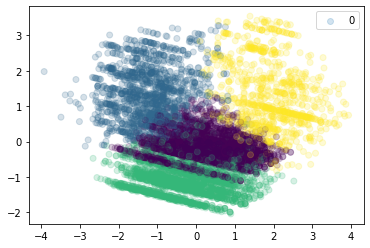

In [100]:
plt.scatter(X_pca[:,0],X_pca[:,1], c=data2["cluster"], alpha=0.2)

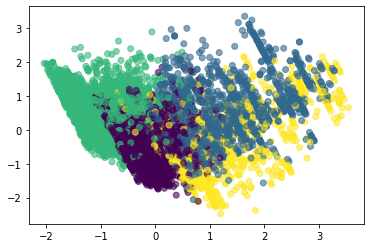

In [35]:
plt.scatter(X_pca[:,1],X_pca[:,2], c=data2["cluster"], alpha=0.6)

<ipython-input-36-3c0a852efcad>:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


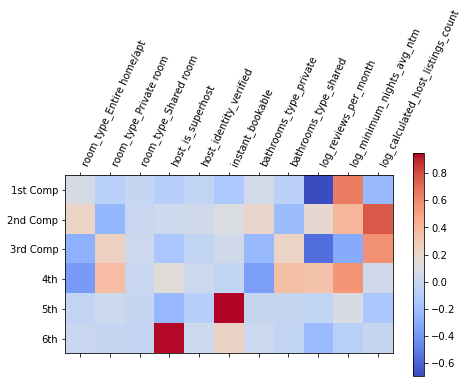

In [36]:
plt.matshow(pca.components_[0:6], cmap='coolwarm')
plt.yticks([0,1,2,3,4,5],['1st Comp','2nd Comp','3rd Comp','4th','5th','6th'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(data_cluster.columns)),data_cluster.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()# 

## t-SNE visualization

In [133]:
#visualize using t-SNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_cluster)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/Users/test/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/test/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8289 samples in 0.008s...
[t-SNE] Computed neighbors for 8289 samples in 0.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8289
[t-SNE] Computed conditional probabilities for sample 2000 / 8289
[t-SNE] Computed conditional probabilities for sample 3000 / 8289
[t-SNE] Computed conditional probabilities for sample 4000 / 8289
[t-SNE] Computed conditional probabilities for sample 5000 / 8289
[t-SNE] Computed conditional probabilities for sample 6000 / 8289
[t-SNE] Computed conditional probabilities for sample 7000 / 8289
[t-SNE] Computed conditional probabilities for sample 8000 / 8289
[t-SNE] Computed conditional probabilities for sample 8289 / 8289
[t-SNE] Mean sigma: 0.229687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.000221
[t-SNE] KL divergence after 300 iterations: 1.939352
t-SNE done! Time elapsed: 23.67288613319397 seconds


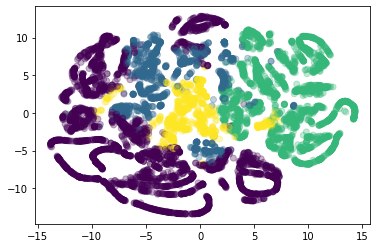

In [131]:
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=data2["cluster"], alpha=0.3)

In [74]:
data_original['cluster']=clusters

In [78]:
data_original.cluster.value_counts()

0    3553
2    2422
1    1405
3     909
Name: cluster, dtype: int64

### room types (% for each cluste) in different clusters

In [127]:
group_room=data_original.groupby(['cluster','room_type']).agg({'room_type': 'count'}).apply(lambda x:  100*x / x.sum())
group_room.groupby(level=0).apply(lambda x:  100*x / x.sum())

room_type
cluster room_type                 
0       Entire home/apt  99.859274
        Private room      0.140726
1       Entire home/apt  78.149466
        Private room     16.370107
        Shared room       5.480427
2       Entire home/apt   0.041288
        Private room     99.298101
        Shared room       0.660611
3       Entire home/apt  86.028603
        Private room     13.091309
        Shared room       0.880088

In [88]:
data2.groupby(['cluster']).agg({'host_is_superhost':'sum','host_identity_verified':'sum','instant_bookable':'sum','bathrooms_type_private':'sum','bathrooms_type_shared':'sum'}).apply(lambda x:  100*x / x.sum())

,host_is_superhost,host_identity_verified,instant_bookable,bathrooms_type_private,bathrooms_type_shared
cluster,,,,,
0,39.152542,42.460210,33.689459,58.034984,0.138122
1,18.305085,18.195306,36.004274,20.843551,5.985267
2,31.101695,27.825735,23.931624,7.650809,89.963168
3,11.440678,11.518748,6.374644,13.470656,3.913444


In [67]:
data2.groupby(['cluster']).agg({'reviews_per_month':'mean','minimum_nights_avg_ntm':'mean','calculated_host_listings_count':'mean'})

,reviews_per_month,minimum_nights_avg_ntm,calculated_host_listings_count
cluster,,,
0,0.891146,3.661441,1.225725
1,2.317011,2.743630,12.393594
2,0.974290,2.956111,1.374484
3,0.495754,70.121562,5.619362


## cluster 0: most entire homes, superhost, host verified

## cluster 1: entire homes, host with many listings, many reviews per month

### cluster 0+1 look more professional

## cluster 2: most private rooms, shared bathroom --> more non-professional

In [105]:
# I didnt use price ro cluster but this category has lowest price and accomodates the lowest amount of people
data2.groupby(['cluster']).agg({'price':'mean','accommodates':'mean'})

,price,accommodates
cluster,,
0,96.378553,3.303124
1,123.516726,4.211388
2,45.492568,1.998348
3,69.732673,2.564356


In [129]:
data2.groupby(['cluster']).agg({'availability_365':'mean'})
#availability seems higher in cluster 1 and 3, meaning its rented out for longer periods

#avialability is however from the calender, can be blocked by host but can also mean its rented out already

,availability_365
cluster,
0,96.536167
1,239.308897
2,87.644509
3,167.863586


In [126]:
# nolarge difference in host location in clusters
HL=data2.groupby(['cluster','Host_location_germany']).agg({'Host_location_germany':'count'})
HL.groupby(level=0).apply(lambda x:  100*x / x.sum())

Host_location_germany
cluster Host_location_germany                       
0       False                               6.163805
        True                               93.836195
1       False                               5.053381
        True                               94.946619
2       False                               5.202312
        True                               94.797688
3       False                               9.790979
        True                               90.209021

In [178]:
data_cluster

,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost,host_identity_verified,instant_bookable,bathrooms_type_private,bathrooms_type_shared,log_reviews_per_month,log_minimum_nights_avg_ntm,log_calculated_host_listings_count
0,1,0,0,1,0,0,1,0,1.075374,2.739150,0.833278
1,1,0,0,0,1,0,1,0,0.432870,2.814852,-0.622934
2,0,1,0,1,1,1,0,1,1.021015,-1.101451,-0.622934
3,1,0,0,0,1,0,1,0,-1.480865,0.450385,-0.622934
4,1,0,0,1,1,0,1,0,-0.940253,2.842644,0.531087
...,...,...,...,...,...,...,...,...,...,...,...
8284,1,0,0,0,1,0,1,0,0.458525,-0.149948,-0.622934
8285,1,0,0,0,1,1,1,0,0.458525,-1.101451,-0.622934
8286,0,1,0,0,1,1,0,1,0.458525,-1.101451,3.507194
8287,1,0,0,0,1,0,1,0,0.458525,-0.501119,-0.622934


## cluster 3: entire homes, minimum nights average is high, hosts also have more than 1 listing, more often hosts not in germany that in other groups